In [1]:
'''
Some libs for math
'''
from math import log2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import math

frac_cache = dict()

def frac(n:int):
    """
    Calculate the frac: n!
    """
    if n <= 0:
        return 1
    if n in frac_cache:
        return frac_cache[n]
    frac_cache[n] = frac(n-1) * n
    return frac_cache[n]

def comb(n:int,m:int):
    """
    Calculate the combination number: pick m items from n items
    """
    if m>n:
        return 0
    elif m==n:
        return 1
    return (frac(n)/frac(n-m))/frac(m)

random.seed(20220622)

# generate bernoulli r.v.
def bernoulli(p):
    if random.random()<p:
        return 1
    else:
        return 0

# Experiment 1: Symmetric Noise

To get some intuition, we perform the experiment 1. The result may not be shown in the paper.

In this experiment, we compute and plot the expected scores and performance ratios of a simulated classifier vs. a source panel, under various choices of noise level of source panel, noise level of target raters, number of target raters, and scoring function.

We will plot different level of target panel noise (or target panel size) on the x-axis and performance ratio on the y-axis. The y-axis will be the performance ratio of the simulated classifier with various source panels. Ideally, we want a scoring mechanism such that the performance ratio is to affected by the target panel size.

Our scoring functions operate very nicely on confusion matrices (joint distribution of classifier output and majority vote of target panel), so we compute those confusion matrices for both the classifier and a source panel.

## Version 1: Vary target panel noise
In this version, we do not explicitly model the noise of a single rater. Instead, we have a noise matrix for a panel of size k.

### Distribution of Ground Truth
First, we define a diagonal matrix that shows the joint distribution of ground truth and **non-noisy** target panel (t=inf).

Note that, in our case, we are picking target noise such that with infinite raters we get the ground truth.

So, for example, if the ground truth is 0 on 60\% of items:

$$GT = \begin{bmatrix} Pr[\infty target=0,GT=0] & Pr[\infty target=1,GT=0] \\ Pr[\infty target=0,GT=1] & Pr[\infty target=1,GT=1] \end{bmatrix} = \begin{bmatrix} 0.6 & 0 \\ 0 & 0.4 \end{bmatrix}$$

### Classifier noise matrix
Then, we define the noise of the classifier by saying how often it makes mistakes when ground truth is 0 and how often it makes mistakes when ground truth is 1. In our case, we are assuming symmetric noise, so we have a single parameter *q*.

$$Classifier\_noise = \begin{bmatrix} Pr[classifier=0|GT=0] & Pr[classifier=0|GT=1] \\ Pr[classifier=1|GT=0] & Pr[classifier=1|GT=1] \end{bmatrix}= \begin{bmatrix} q & 1-q \\ 1-q & q\end{bmatrix}$$

### Classifier confusion matrix
From this, we can compute the confusion matrix of the classifier with ground truth, i.e., the joint distribution.

$$Classifier\_confusion = Classifier\_noise * GT = \begin{bmatrix} Pr[classifier=0,\infty target=0] & Pr[classifier=0,\infty target=1] \\ Pr[classifier=1,\infty target=0] & Pr[classifier=1,\infty target=1] \end{bmatrix} = 
\begin{bmatrix} 0.6q & 0.4(1-q) \\ 0.6(1-q) & 0.4q\end{bmatrix}
$$

Note that here the column is ground truth. This matrix is normalized (all entries sum to 1).

### k-target noise matrix
For a target panel with k -raters, again assuming symmetric noise we have just one parameter *p*. We define the k-target noise matrix as:

$$k\_Noise = \begin{bmatrix} Pr[k~target = 0|\infty target=0] & Pr[k~target = 1|\infty target=0] \\ Pr[k~target = 0|\infty target=1] & Pr[k~target = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p & 1-p \\ 1-p & p\end{bmatrix}$$

### k-target confusion matrix with classifier (not ground truth)

Therefore, the joint distribution of k-target panel and classifier output is
$$
k\_vs\_classifier\_confusion = Classifier\_noise * GT * k\_Noise = \begin{bmatrix} Pr[classifier=0,k~target=0] & Pr[classifier=0,k~target=1] \\ Pr[classifier=1,k~target=0] & Pr[classifier=1,k~target=1] \end{bmatrix}
$$

### k-target confusion matrix with source panel (not ground truth)

Similarly, if we represent the source panel's outputs as a noise matrix with respect to the ground truth, 
the joint distribution of k-target panel and source-panel output is
$$
k\_vs\_source\_confusion = Source\_noise * GT * k\_Noise = \begin{bmatrix} Pr[source=0,k~target=0] & Pr[source=0,k~target=1] \\ Pr[source=1,k~target=0] & Pr[source=1,k~target=1] \end{bmatrix}
$$

With this joint distribution, we can easily calculate the Shannon Mutual Information, DMI, Accuracy, and any other scores.

In [2]:
'''
Some code for score calculations.
'''
import numpy as np
from matplotlib import pyplot as plt

def dmi( u ):
    "This calculates the dmi of joint distribution u"
    import numpy.linalg as lin
    return abs(lin.det(u))

def smi( u ):
    "This calculates the smi of joint distribution u"
    import numpy as np
    m,n = u.shape
    v = 0
    ux = np.empty(m)
    uy = np.empty(n)
    for i in range(m):
       	ux[i] = sum(u[i,:])
    for j in range(n):
   	    uy[j] = sum(u[:,j])
    for i in range(m):
   	    for j in range(n):
   		    if u[i][j] != 0:
   			    v = v + u[i][j] * (np.log(u[i][j])-np.log(ux[i]*uy[j]))
    return v

def acc( u ):
    "This calculates the agreement score of joint distribution u"
    return np.trace(u)

source_error = 0.1
dmi_score : ratio between performance ratios of largest and smallest target error:		0.9999999999999991
smi_score : ratio between performance ratios of largest and smallest target error:		1.0631141931055368
agreement_score : ratio between performance ratios of largest and smallest target error:	1.086206896551724

source_error = 0.15
dmi_score : ratio between performance ratios of largest and smallest target error:		0.9999999999999997
smi_score : ratio between performance ratios of largest and smallest target error:		1.0258699746605933
agreement_score : ratio between performance ratios of largest and smallest target error:	1.043859649122807

source_error = 0.2
dmi_score : ratio between performance ratios of largest and smallest target error:		0.9999999999999996
smi_score : ratio between performance ratios of largest and smallest target error:		0.999999999999997
agreement_score : ratio between performance ratios of largest and smallest target error:	0.9999999999999998



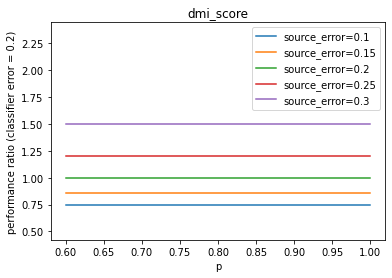

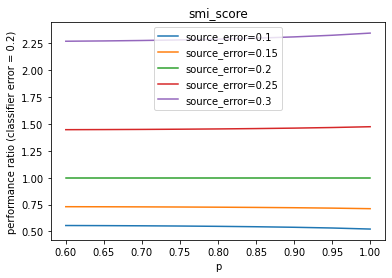

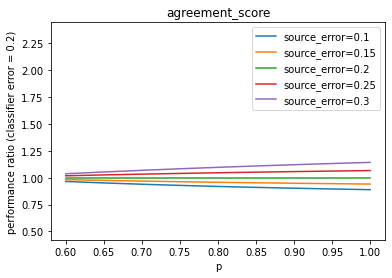

In [3]:
'''
Main code for experiment 1
'''

GT = np.array([[0.6,0.],[0.,0.4]])

# p is target noise, which we will vary
p_values = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
# source_error is the noise of the source panel, which we will vary
source_error = [0.1,0.15,0.2,0.25,0.3]
# q is the classifier noise, according to the definition above
q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for p in p_values:
        k_noise = np.array([[p,1-p],[1-p,p]])
        
        k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_classifier_confusion)/dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_classifier_confusion)/smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_classifier_confusion)/acc(k_vs_source_confusion))
        
    # compute the range of y axis based on min and max over all the performance ratios
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print(f'dmi_score : ratio between performance ratios of largest and smallest target error:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'smi_score : ratio between performance ratios of largest and smallest target error:\t\t{smi_score[0]/smi_score[-1]}',)
    print(f'agreement_score : ratio between performance ratios of largest and smallest target error:\t{acc_score[0]/acc_score[-1]}',)
    print()

    fig_dmi.plot(p_values,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(p_values,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(p_values,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('p')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('p')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('p')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusions

1. DMI performance ratio is almost perfectly stable; very little difference between small target panel noise and large.

2. agreement score is not very stable.
    a. when source panel has same noise as classifier (0.2 in the second to last figure above) the performance ratio is 1, regardless of the target panel, because they both make the same kinds of errors.
    b. when source panel has more noise than classifier (>0.2), the performance ratio gets bigger as target panel size increases and noise decreases. At =1 we are getting the real performance ratio. But with some noise in the target panel, more of the classifier's errors look like correct answers, and so the ratio gets closer to 1. With p=0.5 (completely non-informative target), the performance ratio of any pair of classifiers will be exactly 1.
    c. similarly, when source panel has less noise than classifier, the performance diverges from 1 (declines) as the target panel size increases.
    
3. SMI is somewhat stable.
    a. when source panel has same noise as classifier (0.2 in the second to last figure above) the performance ratio is 1, regardless of the target panel, because they both make the same kinds of errors.
    b. when source panel has more or less noise, it appears that it diverges monotonically, as with agreement score.


## Version 2: Model Individual target rater noise

Almost everything is the same here except:
- we model the noise of an individual target rater and then, for a given target panel size, that implies a value of the parameter *p* based on the probability that the majority vote of a panel of that size will be correct.


In [4]:
 def calc_panel_acc(rater_error,panel_size):
    '''
    Calculate the error of the majority vote among the target panel
    '''
    ans = 0
    for i in range((panel_size+1)//2):
        ans += comb(panel_size,i) * ((1-rater_error) ** (panel_size-i)) * (rater_error ** i)
    return ans


In [5]:
# unit tests for calc_panel_acc
# when t_size = 3, it should be 0.6**3 + 3*(0.6**2)*0.4 = 0.648 (checked)
assert(calc_panel_acc(rater_error=0.4,panel_size=3) == 0.6**3 + 3*(0.6**2)*0.4)

assert(calc_panel_acc(rater_error=0.2,panel_size=3) == 0.8**3 + 3*(0.8**2)*0.2)

t_size = 5
assert(calc_panel_acc(rater_error=0.2,panel_size=5) == \
      .8**5 + \
      .8**4 *.2*5 + \
      .8**3 *.2**2 * 10)

### Plot target panel size vs. panel accuracy

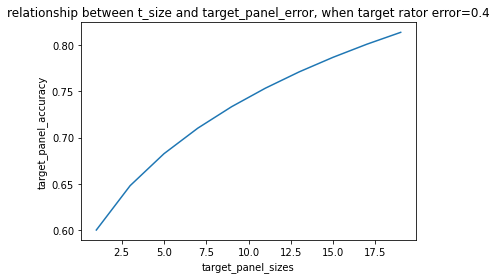

In [6]:
target_panel_sizes = [1,3,5,7,9,11,13,15,17,19]

p_values = [calc_panel_acc(rater_error=.4, panel_size=t) for t in target_panel_sizes]    
    
plt.figure()
plt.plot(target_panel_sizes,p_values)
plt.xlabel('target_panel_sizes')
plt.ylabel('target_panel_accuracy')
plt.title('relationship between t_size and target_panel_error, when target rator error=0.4')
plt.show()

source_error = 0
dmi_score : ratio between performance ratios of smallest and largest target size:		0.9999999999999992
smi_score : ratio between performance ratios of smallest and largest target size:		1.0421310481353214
agreement_score : ratio between performance ratios of smallest and largest target size:		1.103585675172085

source_error = 0.1
dmi_score : ratio between performance ratios of smallest and largest target size:		0.9999999999999988
smi_score : ratio between performance ratios of smallest and largest target size:		1.0157599859159578
agreement_score : ratio between performance ratios of smallest and largest target size:		1.0535787975028026

source_error = 0.15
dmi_score : ratio between performance ratios of smallest and largest target size:		0.9999999999999993
smi_score : ratio between performance ratios of smallest and largest target size:		1.0069106971623638
agreement_score : ratio between performance ratios of smallest and largest target size:		1.02725938820318

source_e

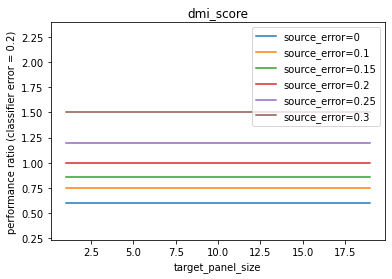

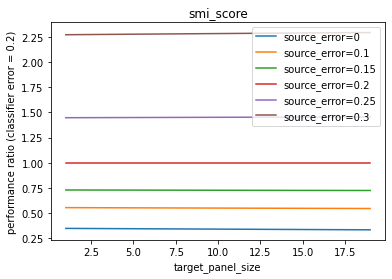

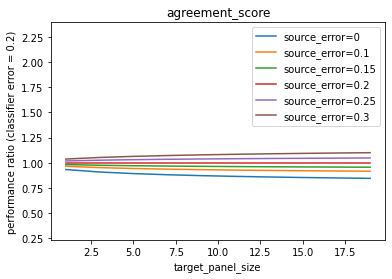

In [7]:
'''
Main code for experiment 1, version 2
'''

GT = np.array([[0.6,0.],[0.,0.4]])

target_error = 0.4
target_panel_sizes = [1,3,5,7,9,11,13,15,17,19]
source_error = [0,0.1,0.15,0.2,0.25,0.3]
q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
           
        p = calc_panel_acc (rater_error = target_error,panel_size = t)
        
        k_noise = np.array([[p,1-p],[1-p,p]])
        
        k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_classifier_confusion)/dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_classifier_confusion)/smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_classifier_confusion)/acc(k_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}',)
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}',)
    print()

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

## Version 3: Model source panel noise based on individual rater noise

Almost everything is the same here except:
- using the same noise for an individual rater (we assume source raters and target raters are drawn from the same pool), we can also compute the source panel noise in a similar way.

This allows to also see how the survey equivalence changes with the size of the target panel.


source_panel_size = 3
source_error = 0.352
dmi_score : ratio between performance ratios of smallest and largest target size:		0.9999999999999989
		 smallest performance ratio 2.0270270270270254, 	 largest 2.0270270270270285
smi_score : ratio between performance ratios of smallest and largest target size:		0.9817964109816267
		 smallest performance ratio 4.159555520918009, 	 largest 4.236678270965742
agreement_score : ratio between performance ratios of smallest and largest target size:		0.8945952922777161
		 smallest performance ratio 1.0574018126888218, 	 largest 1.1819890198578917

source_panel_size = 7
source_error = 0.28979200000000005
dmi_score : ratio between performance ratios of smallest and largest target size:		0.9999999999999992
		 smallest performance ratio 1.4271578626883845, 	 largest 1.427157862688386
smi_score : ratio between performance ratios of smallest and largest target size:		0.987361302983621
		 smallest performance ratio 2.053727802079625, 	 largest 2.0800165004

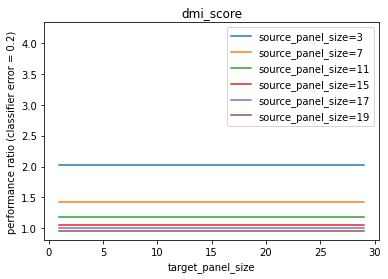

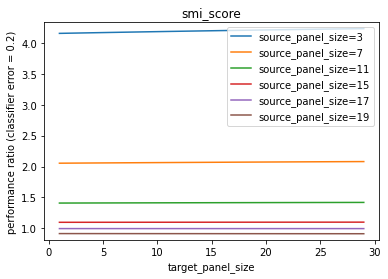

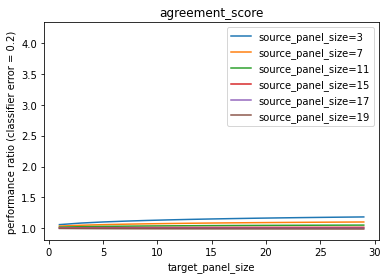

In [8]:
# code goes here

'''
Main code for experiment 1, version 2
'''

GT = np.array([[0.6,0.],[0.,0.4]])

rater_error = 0.4

target_error = rater_error
source_error = rater_error

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
source_panel_size = [3,7,11,15,17,19]

q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    s = calc_panel_acc (rater_error = source_error, panel_size = s_size)
    source_panel = np.dot(np.array([[s,1-s],[1-s,s]]),GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
           
        p = calc_panel_acc (rater_error = target_error,panel_size = t)
        
        k_noise = np.array([[p,1-p],[1-p,p]])
        
        k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_classifier_confusion)/dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_classifier_confusion)/smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_classifier_confusion)/acc(k_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print('source_error = '+str(1-s))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print()

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusions: Survey equivalence does not change

Note that for all scorers, the smallest and largest performance ratio for different target size are either both >1 or <1.

That means, survey equivalence does not change for different target panel size

# Experiment 2 with asymmetric noise

Here, we introduce asymmetric noise to the **individual panel raters**, while the classifier noise is still symmetric.

$$Rater\_noise = \begin{bmatrix} Pr[rater = 0|\infty target=0] & Pr[rater = 1|\infty target=0] \\ Pr[rater = 0|\infty target=1] & Pr[rater = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p_{neg} & 1-p_{neg} \\ 1-p_{pos} & p_{pos}\end{bmatrix}$$

Then we recover the k-noise matrix by calculation

### k-target noise matrix
For a target panel with k -raters, again assuming symmetric noise we have just one parameter *p*. We define the k-target noise matrix as:

$$k\_Noise = \begin{bmatrix} Pr[k~target = 0|\infty target=0] & Pr[k~target = 1|\infty target=0] \\ Pr[k~target = 0|\infty target=1] & Pr[k~target = 1|\infty target=1] \end{bmatrix}$$


In [9]:
def calc_panel_noise_matrix(p_neg,p_pos,panel_size):
    
    ans = np.zeros((2,2))
    
    for i in range((panel_size+1)//2):
        ans[0,0] += comb(panel_size,i) * (p_neg ** (panel_size-i)) * ((1-p_neg) ** i)
        ans[1,1] += comb(panel_size,i) * (p_pos ** (panel_size-i)) * ((1-p_pos) ** i)
    
    ans[0,1] = 1-ans[0,0]
    ans[1,0] = 1-ans[1,1]
        
    return ans

### k-target confusion matrix with classifier

Therefore, the joint distribution of k-target panel and classifier output is
$$
k\_vs\_classifier\_confusion = Classifier\_noise * GT * k\_Noise = \begin{bmatrix} Pr[classifier=0,k~target=0] & Pr[classifier=0,k~target=1] \\ Pr[classifier=1,k~target=0] & Pr[classifier=1,k~target=1] \end{bmatrix}
$$

### k-target confusion matrix with source panel

Similarly, if we represent the source panel's outputs as a noise matrix with respect to the ground truth, 
the joint distribution of k-target panel and source-panel output is
$$
k\_vs\_source\_confusion = Source\_noise * GT * k\_Noise = \begin{bmatrix} Pr[source=0,k~target=0] & Pr[source=0,k~target=1] \\ Pr[source=1,k~target=0] & Pr[source=1,k~target=1] \end{bmatrix}
$$

We can also calculate source_noise matrix using calc_panel_noise_matrix, however, **here we need transpose it**, according to the folloing definition

### Source noise matrix

$$Source\_noise = \begin{bmatrix} Pr[source=0|GT=0] & Pr[source=0|GT=1] \\ Pr[source=1|GT=0] & Pr[source=1|GT=1] \end{bmatrix}$$

source_panel_size = 1
dmi_score : ratio between performance ratios of smallest and largest target size:		1.0
		 smallest performance ratio 1.714285714285714, 	 largest 1.7142857142857155
smi_score : ratio between performance ratios of smallest and largest target size:		0.9601322081278453
		 smallest performance ratio 2.8552345334515707, 	 largest 2.9737930977432487
agreement_score : ratio between performance ratios of smallest and largest target size:		0.9393138104886192
		 smallest performance ratio 1.0531732418524873, 	 largest 1.1212155406345403

source_panel_size = 3
dmi_score : ratio between performance ratios of smallest and largest target size:		1.0000000000000004
		 smallest performance ratio 1.2201321809862733, 	 largest 1.2201321809862744
smi_score : ratio between performance ratios of smallest and largest target size:		0.9618998504802341
		 smallest performance ratio 1.3933515171220656, 	 largest 1.4485411515829083
agreement_score : ratio between performance ratios of smalle

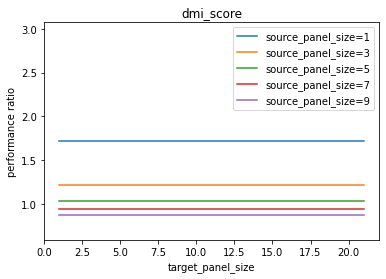

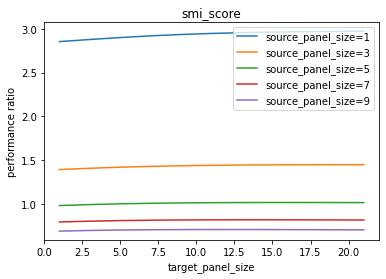

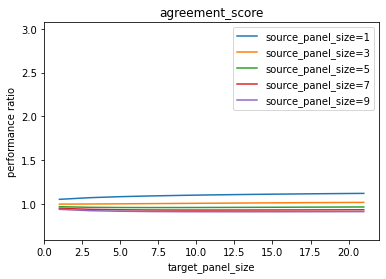

In [10]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21]
source_panel_size = [1,3,5,7,9]

q = 0.8

classifier_noise = np.array([[q,1-q],[1-q,q]])
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
    
        k_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_classifier_confusion)/dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_classifier_confusion)/smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_classifier_confusion)/acc(k_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print()

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

### Conclusion

DMI is still stable! However, for other two scorers, both performance ratio and survey equivalence are not stable.

Interestingly, in the symmetric case, the survey equivalence for all three classifier is the same. In the asymmetric the DMI's seq is between 5 to 7 while the agreement's seq is less than 5.

That is because when in the asymmetric case we have different confusion matrix for classifier v.s. target panel and source panel v.s. source panel. So the score is changing in different ways. 

For DMI, when you multiply some target noise matrix, you change the score by multiply a determint of that matrix. So when target panel size goes up, every score will have the same change.

### Classifier asymmetric noise

We can easily give some experiment for asymmetric noise classifier. The result is similar, DMI is stable.

$$Classifier\_noise = \begin{bmatrix} Pr[classifier=0|GT=0] & Pr[classifier=0|GT=1] \\ Pr[classifier=1|GT=0] & Pr[classifier=1|GT=1] \end{bmatrix}= \begin{bmatrix} q_0 & 1-q_1 \\ 1-q_0 & q_1\end{bmatrix}$$

source_panel_size = 1
dmi_score : ratio between performance ratios of smallest and largest target size:		1.0
		 smallest performance ratio 1.4285714285714286, 	 largest 1.4285714285714295
smi_score : ratio between performance ratios of smallest and largest target size:		0.9554780209839601
		 smallest performance ratio 1.9632923915381255, 	 largest 2.0547750428799074
agreement_score : ratio between performance ratios of smallest and largest target size:		0.9693821946471036
		 smallest performance ratio 1.0017152658662094, 	 largest 1.033354306895307

source_panel_size = 3
dmi_score : ratio between performance ratios of smallest and largest target size:		1.0000000000000002
		 smallest performance ratio 1.016776817488561, 	 largest 1.0167768174885619
smi_score : ratio between performance ratios of smallest and largest target size:		0.957237094788974
		 smallest performance ratio 0.958084668791449, 	 largest 1.0016334123300628
agreement_score : ratio between performance ratios of smallest 

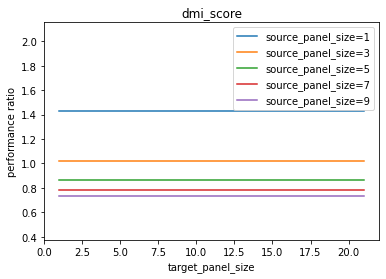

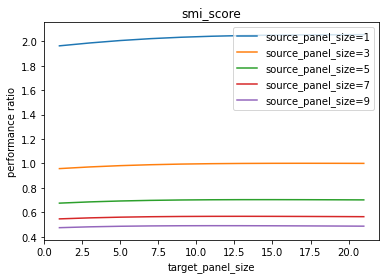

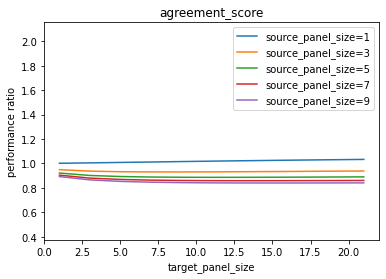

In [11]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,3,5,7,9,11,13,15,17,19,21]
source_panel_size = [1,3,5,7,9]

classifier_noise = np.array([[0.7,0.3],[0.2,0.8]]).T
classifier_confusion = np.dot(classifier_noise,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s_size in source_panel_size:
    
    source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)
    
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
    
        k_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
        
        k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_classifier_confusion)/dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_classifier_confusion)/smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_classifier_confusion)/acc(k_vs_source_confusion))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_panel_size = '+str(s_size))
    print(f'dmi_score : ratio between performance ratios of smallest and largest target size:\t\t{dmi_score[0]/dmi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(dmi_score)}, \t largest {np.max(dmi_score)}')
    print(f'smi_score : ratio between performance ratios of smallest and largest target size:\t\t{smi_score[0]/smi_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(smi_score)}, \t largest {np.max(smi_score)}')
    print(f'agreement_score : ratio between performance ratios of smallest and largest target size:\t\t{acc_score[0]/acc_score[-1]}')
    print(f'\t\t smallest performance ratio {np.min(acc_score)}, \t largest {np.max(acc_score)}')
    print()

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_panel_size='+str(s_size))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_panel_size='+str(s_size))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_panel_size='+str(s_size))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

# Experiment 3: Power Curve

In this experiment, we draw several figures for power curve, i.e. the source panel's score curve for different source panel size, and show the survey equivalence on the figures. The score is according to the target panel size. 

### Figure

There are totally 15 figures, the column is for different scorers (dmi, acc, smi), and the row is for different target panel size [1,5,9,21,99].

In each figure, the x-axis is source panel size, the y-axis is score. The horizontal line shows the classifier's score. The vertical line shows the survey equivalence.

### Noise

They are all using the same asymmetric noise rater, and asymmetric classifier. The noise is defined in experiment 2.

In [12]:
def seq(source_panel_size,classifier_score,source_panel_score):
    
    seq = None
    
    for i in range(len(source_panel_size)-1):
        if classifier_score >= source_panel_score[i] and classifier_score <= source_panel_score[i+1]:
            seq = ((classifier_score-source_panel_score[i])/(source_panel_score[i+1]-source_panel_score[i]))*(source_panel_size[i+1]-source_panel_size[i])+source_panel_size[i]
            
    return seq
            

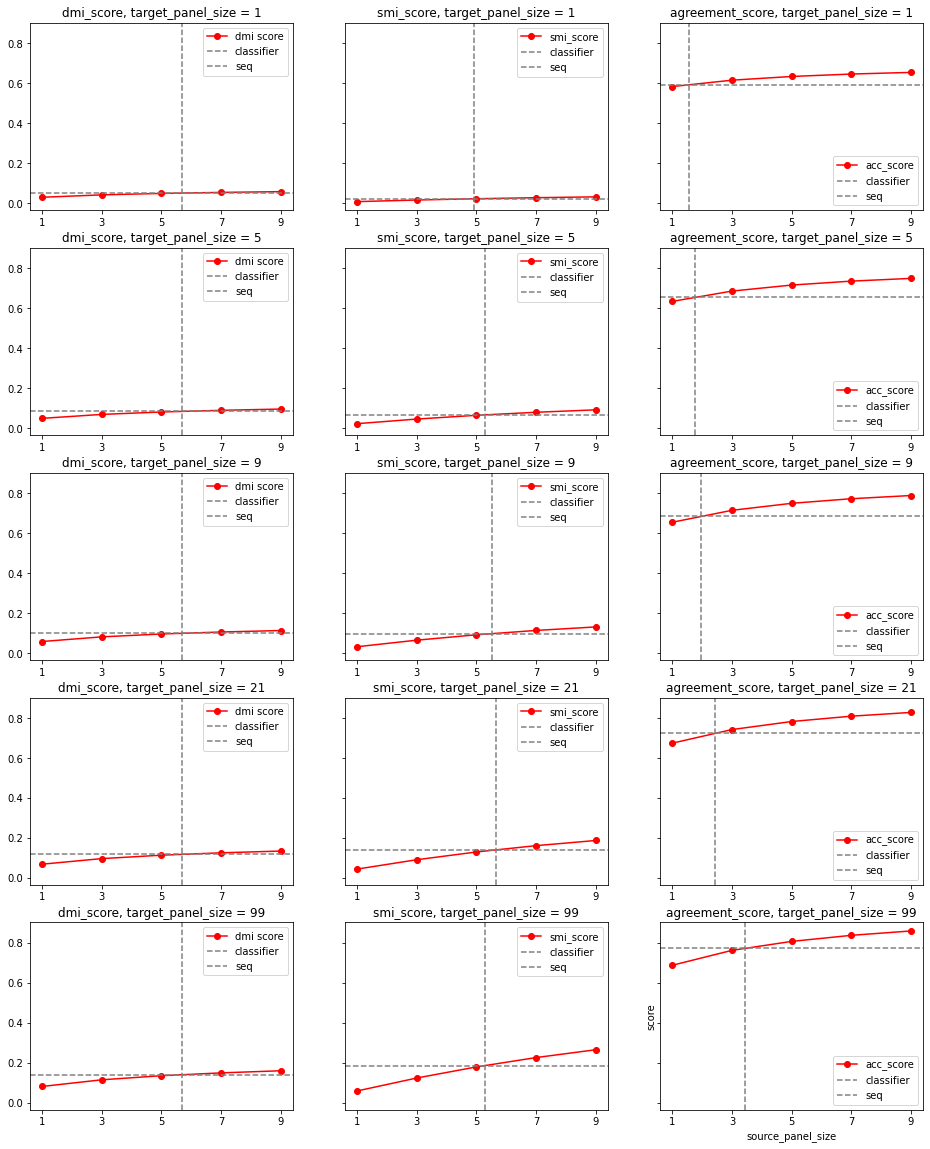

In [13]:
p_neg = 0.75
p_pos = 0.6

GT = np.array([[0.6,0.],[0.,0.4]])

target_panel_sizes = [1,5,9,21,99]
source_panel_size = [1,3,5,7,9]

classifier_noise = np.array([[0.7,0.3],[0.1,0.9]]).T
classifier_confusion = np.dot(classifier_noise,GT)


fig,axs = plt.subplots(5, 3, sharex=False, sharey=True, figsize=(16, 20))

i = 0

for t in target_panel_sizes:
    
    k_noise = calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=t)
    k_vs_classifier_confusion = np.dot(classifier_confusion,k_noise)
    
    dmi_score = []
    smi_score = []
    acc_score = []

    for s_size in source_panel_size:
    
        source_panel = np.dot(calc_panel_noise_matrix(p_neg=p_neg,p_pos=p_pos,panel_size=s_size).T,GT)

        k_vs_source_confusion = np.dot(source_panel,k_noise)
        
        dmi_score.append(dmi(k_vs_source_confusion))
        smi_score.append(smi(k_vs_source_confusion))
        acc_score.append(acc(k_vs_source_confusion))

    axs[i,0].plot(source_panel_size,dmi_score,label = 'dmi score', marker = 'o',color = 'r')
    axs[i,0].axhline(dmi(k_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,0].axvline(seq(source_panel_size,dmi(k_vs_classifier_confusion),dmi_score), color='grey',label='seq',ls = 'dashed')
    axs[i,0].set_title('dmi_score, target_panel_size = '+str(t))
    
    axs[i,1].plot(source_panel_size,smi_score,label = 'smi_score', marker = 'o',color = 'r')
    axs[i,1].axhline(smi(k_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,1].axvline(seq(source_panel_size,smi(k_vs_classifier_confusion),smi_score),color='grey',label='seq',ls = 'dashed')
    axs[i,1].set_title('smi_score, target_panel_size = '+str(t))
    
    axs[i,2].plot(source_panel_size,acc_score,label = 'acc_score', marker = 'o',color = 'r')
    axs[i,2].axhline(acc(k_vs_classifier_confusion),color='grey',label='classifier',ls = 'dashed')
    axs[i,2].axvline(seq(source_panel_size,acc(k_vs_classifier_confusion),acc_score),color='grey',label='seq',ls = 'dashed')
    axs[i,2].set_title('agreement_score, target_panel_size = '+str(t))
    
    for j in range(3):
        axs[i,j].legend()
        axs[i,j].set_xticks(source_panel_size)

    i += 1

plt.xlabel('source_panel_size')
plt.ylabel('score')
fig.show()

### Conclusion

For different target_panel_size:

The seq for dmi does not change.

The seq for agreement_score changes monotonically.
    
The seq for smi increases when target_panel_size is small and decreases when target_panel_size is large. That is caused by different increase rate of source_panel_score and classifier_score when target_panel_size increases.

# Experiment 4: Synthetic Dataset

Here we no longer assume that we have specified confusion matrices (or enough info to compute them). Instead, we have a dataset of labels and we will calculate scores.

We still generate the synthetic dataset of labels from a model where we do know the confusion matrix (joint distribution).

We're testing how stable things are with smaller datasets that leave us with some uncertainty about the confusion matrices.

The first code block is for some simple math. The second code block is for scores.



In [14]:
'''
Scorers
'''



def agreement_score(W,hard_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr[int(hard_classifier[i])]
        
    return ans/W.shape[0]

def cross_entropy_score(W,soft_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr[0]*log2(soft_classifier[i,0]) + pr[1]*log2(soft_classifier[i,1])
        
    return ans/W.shape[0]

def dmi_score(W,soft_classifier,t_size):
    ans = np.zeros((2,2))
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr.reshape(2,1).dot(soft_classifier[i].reshape(1,2))
        
    ans = ans/W.shape[0]
    
    import numpy.linalg as lin
    return abs(lin.det(ans))

# import unittest

# class TestScoringFunctions(unittest.TestCase):
#     W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    
#     def test_agreement_score(self):
#         '''
#         majority of 3 raters
#         score = 1/4 * (1/2 + 1 + 1 + 0)
#         '''
#         t_size = 3
#         hard_classifier = np.array([1,1,1,1])
#         score = agreement_score(W=self.W,hard_classifier=hard_classifier,t_size=t_size)
#         print(score)
#         self.asserAlmostEqual(score,0.625,delta=0.001)
    
#     def test_CE_score(self):
#         '''
#         majority of 3 raters
#         score = 1/4 * (1/2 + 1 + 1 + 0)
#         '''
#         t_size = 3
#         soft_classifier = np.array([[0.2,0.8],[0.3,0.7],[0.6,0.4],[0.2,0.8]])
#         score = cross_entropy_score(W=self.W,soft_classifier=soft_classifier,t_size=t_size)
#         ground_truth = 1/4 * (log2(0.2)*1/2+log2(0.8)*1/2+log2(0.7)*1+log2(0.4)*1+log2(0.2)*1)
#         print(score,ground_truth)
#         self.asserAlmostEqual(score,ground_truth,delta=0.001)

def test_agreement_score():
    '''
    majority of 3 raters
    score = 1/4 * (1/2 + 1 + 1 + 0)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    hard_classifier = np.array([1,1,1,1])
    score = agreement_score(W=W,hard_classifier=hard_classifier,t_size=t_size)
    print('test_agreement_score',score == 1/4 * (1/2 + 1 + 1 + 0))

def test_CE_score():
    '''
    majority of 3 raters
    score = 1/4 * (log2(0.2)*1/2 + log2(0.8)*1/2 + log2(0.7)*1 + log2(0.4)*1 + log2(0.2)*1)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    soft_classifier = np.array([[0.2,0.8],[0.3,0.7],[0.6,0.4],[0.2,0.8]])
    score = cross_entropy_score(W=W,soft_classifier=soft_classifier,t_size=t_size)
    ground_truth = 1/4 * (log2(0.2)*1/2+log2(0.8)*1/2+log2(0.7)*1+log2(0.4)*1+log2(0.2)*1)
    print('test_CE_score', score == ground_truth)

test_agreement_score()
test_CE_score()


test_agreement_score True
test_CE_score True


### Dataset Generation

There are two states 0,1.

For the hard classifier, with probability classifier_error, the state with be reversed. Otherwises, classifier will output the ground truth.

For the soft classifier, when ground truth is 0, it will output (1-classifier_error, classifier_error), when ground truth is 1, it will output (classifier_error, 1-classifier_error)

For the rater, the target raters and source raters have the same error.

In [15]:
# parameters
item_size = 300
rater_size = 20

# split target and sourse raters
target_raters = dict()
source_raters = dict()

# classifier output, an integer, 0/1
hard_classifier_output = np.zeros(item_size)
# classifier output
soft_classifier_output = np.zeros((item_size,2))

calibrated_output = np.zeros((item_size,2))
# ground truth
ground_truth = np.zeros(item_size)

# classifier error and rater error
prior = 0.5
classfier_error = 0.2

rater_errors = [0.0,0.15,0.2,0.25,0.3,0.35]

# generate dataset
def classifier_data():
    for i in range(item_size):
        item_state = bernoulli(prior)
        ground_truth[i] = item_state
        # use mod as xor
        hard_classifier_output[i] = (ground_truth[i] + bernoulli(classfier_error))%2
        # small trick
        soft_classifier_output[i,0] = abs(1 - ground_truth[i] - classfier_error)
        soft_classifier_output[i,1] = abs(ground_truth[i] - classfier_error)

classifier_data()

for rater_error in rater_errors:

    def synthetic_data():
        # W is the rater dataset
        W = np.zeros((item_size,rater_size))
        for i in range(item_size):
            for j in range(rater_size):
                if ground_truth[i] == 0:
                    W[i][j] = ground_truth[i] + bernoulli(rater_error)
                else:
                    W[i][j] = ground_truth[i] - bernoulli(rater_error)
        return W
    
    target_raters[rater_error] = synthetic_data()
    source_raters[rater_error] = synthetic_data()

# target sizes
# t is odd to avoid tie
t_sizes = [1,3,5,7,9,11,13,15,17]

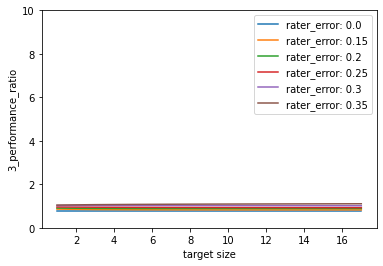

In [16]:
'''
Draw the performance ratio for agreement score
'''

plt.figure()
for r_error in rater_errors:
    
    # Calculate the agreement score of the classifier 
    classifier_acc = []
    for t in t_sizes:
        W = target_raters[r_error]
        classifier_acc.append(agreement_score(W,hard_classifier=hard_classifier_output,t_size=t))

    # Source size 3
    W = source_raters[r_error]
    s=3
    majority_output = np.zeros(item_size)
    W_s = W[...,:s]
    majority_output = np.sum(W_s,axis=1) > (np.ones(item_size)*(s/2.0))

    # Calculate the agreement score of the source majority
    data = []
    for t in t_sizes:
        data.append(agreement_score(W=target_raters[r_error],hard_classifier=majority_output,t_size=t))
    classifier_acc = np.array(classifier_acc)/np.array(data)
    plt.plot(t_sizes,classifier_acc,label = 'rater_error: '+str(r_error))

plt.legend()
plt.ylim(0,10)
plt.xlabel('target size')
plt.ylabel(str(s)+'_performance_ratio')
plt.show()

### Performance (improvement) ratio for ABC+CE

Here we draw the figure for the performance improvement ratio for ABC+CE. The name need to be discussed later. The key point is following the Theorem 1 and 2 in the seq paper.

THEOREM 1 (ABC+CE estimates mutual information). For any fixed set of raters and any $k<\mid$ raters $\mid$, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{SPC}(\mathbf{W}, \mathrm{ABC}(\cdot), \operatorname{CE}(\cdot))_{k}-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}\left(Y_{k+1} ; Y_{1}, Y_{2}, \cdots, Y_{k}\right) .
$$

THEOREM 2 (CE+CALIBRATED CLASSIFIER estimates mutual information). For any calibrated soft classifier $h$, and for any fixed set of raters, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{HScore}(h(I), \mathbf{W}, \operatorname{CE}(\cdot))-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}(h(X) ; Y)
$$


#### Calibration

First, we perform calibration for the Classifier. We use the logistic regreesion to do calibration.

In [17]:
def calibrate(t_size, raters):

    # the majority vote of source panel
    majority_output = np.sum(raters,axis=1) > (np.ones(item_size)*(t_size/2.0))
    
    # logistic regression
    clf = LogisticRegression(random_state=0).fit(soft_classifier_output[:,1:].reshape(-1,1), majority_output.flatten())
    calibrated_output = clf.predict_log_proba(soft_classifier_output[:,1:])
    
    # recover the probability
    calibrated_soft_classifier = np.zeros((item_size,2))
    for i in range(item_size):
        calibrated_soft_classifier[i,1] = math.exp(calibrated_output[i,1])
        calibrated_soft_classifier[i,0] = math.exp(calibrated_output[i,0])
    
    return calibrated_soft_classifier

#### ABC combiner

Then, we define the ABC combiner for target_size > 1

note that we need to make sure that s+t < rater_size

In [18]:
# memoize the sum_of_prob to accelerate
# initial it for different W
sum_of_prob_memo = dict()

def sum_of_prob(W,num_pos,num_neg):
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]
    
    item_size = W.shape[0]
    rater_size = W.shape[1]
    W_count = np.sum(W,axis=1)
    
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]

    v = 0
    for i in range(item_size):
        v += prob_of_one_item(W_count[i],rater_size-W_count[i],num_pos,num_neg)
        
    sum_of_prob_memo[(num_pos,num_neg)] = v
    
    return v

def prob_of_one_item(W_tot_pos,W_tot_neg,num_pos,num_neg):
    if (num_pos>W_tot_pos) or (num_neg>W_tot_neg):
        return 0
    return (comb(W_tot_neg,num_neg)*frac(num_neg)*comb(W_tot_pos,num_pos)*frac(num_pos)*1.0/(comb(W_tot_neg+W_tot_pos,num_pos+num_neg)*frac(num_neg+num_pos)))

def label_seq_prob(W,num_pos,num_neg,exclude_id=-1):
    if exclude_id == -1:
        return sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)/W.shape[0]
    
    return (sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)-prob_of_one_item(np.sum(W[exclude_id]),W.shape[1]-np.sum(W[exclude_id]),num_pos,num_neg))/(W.shape[0]-1)
    
'''
ABC for target panel size >= 1
'''
def ABC(W,num_pos,num_neg,t_size,exclude_id=-1):
    pr = np.zeros(2)
    # for every possible target panel of 0 or 1
    # note that we need to make sure that s+t < rater_size
    for i in range((t_size+1)//2):
        pr[0] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+i,num_neg=num_neg+(t_size-i),exclude_id=exclude_id)
        pr[1] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+(t_size-i),num_neg=num_neg+i,exclude_id=exclude_id)
        
    pr /= label_seq_prob(W=W,num_pos=num_pos,num_neg=num_neg,exclude_id=exclude_id)
    return pr

def test_for_ABC():
    '''
    0 is possible from item 3,4,8 with prob 2/11, from item 5,6 with prob 1/11, from item 7 with prob 3/11
    ABC output 0 with prob 3 * 2/11 * 1/2 + 2 * 1/11 * 0 + 3/11 * 1 = 6/11
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_1',ABC(W=W,num_pos=0,num_neg=1,t_size=1)[0]==6/11)
    
    '''
    0 is possible from item 4,8 with prob 2/9, from item 5,6 with prob 1/9, from item 7 with prob 3/9
    ABC output 0 with prob 2 * 2/9 * 1/2 + 2 * 1/9 * 0 + 3/9 * 1 = 5/9
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_2',ABC(W=W,num_pos=0,num_neg=1,t_size=1,exclude_id = 2)[0]==5/9)
    

test_for_ABC()

test_for_ABC_1 True
test_for_ABC_2 True


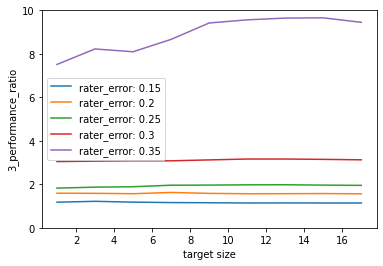

In [19]:
plt.figure()
for r_error in rater_errors:
    
    #clean the memo for different W
    sum_of_prob_memo = dict()
    
    # CE will have problem when r_error = 0
    if r_error < 0.01:
        continue
        
    classifier_acc = []
    prior_pred = np.ones((item_size,2)) * 0.5

    # The CE score for the calibrated classifier
    for t in t_sizes:
        calibrated_soft_classifier = calibrate(t, source_raters[r_error][:,:t])
        classifier_acc.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=calibrated_soft_classifier,t_size=t))

    W = source_raters[r_error]
    s = 3 # s + max(t_sizes) = 20
    W_s_count = np.sum(W[...,:s],axis=1)
    ABC_score = []
    prior_score = []
    
    for t in t_sizes:
        abc_output = np.zeros((item_size,2))
        prior_output = np.zeros((item_size,2))

        for i in range(item_size):
            abc_output[i] = ABC(W = W,num_pos = W_s_count[i],num_neg = s-W_s_count[i],t_size = t,exclude_id = i)
            prior_output[i] = ABC(W = W,num_pos = 0,num_neg = 0,t_size = t,exclude_id = i)
        
        ABC_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=abc_output,t_size=t))
        prior_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=prior_output,t_size=t))
    
    performance_ratio = (np.array(classifier_acc)-np.array(prior_score))/(np.array(ABC_score)-np.array(prior_score))
    plt.plot(t_sizes,performance_ratio,label = 'rater_error: '+str(r_error))


plt.legend()
plt.ylim(0,10)
plt.xlabel('target size')
plt.ylabel(str(s)+'_performance_ratio')
plt.show()


## synthetic dataset for DMI_score

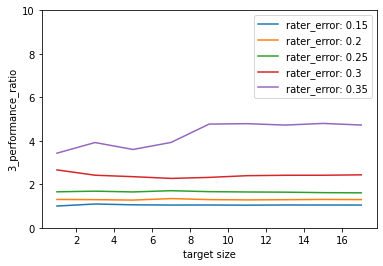

In [20]:
plt.figure()
for r_error in rater_errors:
    
    #clean the memo for different W
    sum_of_prob_memo = dict()
    
    # CE will have problem when r_error = 0
    if r_error < 0.01:
        continue
        
    classifier_acc = []
    prior_pred = np.ones((item_size,2)) * 0.5

    # The CE score for the calibrated classifier
    for t in t_sizes:
        calibrated_soft_classifier = calibrate(t, source_raters[r_error][:,:t])
        classifier_acc.append(dmi_score(W=target_raters[r_error],soft_classifier=calibrated_soft_classifier,t_size=t))

    W = source_raters[r_error]
    s = 3 # s + max(t_sizes) = 20
    W_s_count = np.sum(W[...,:s],axis=1)
    ABC_score = []
    prior_score = []
    
    for t in t_sizes:
        abc_output = np.zeros((item_size,2))
        prior_output = np.zeros((item_size,2))

        for i in range(item_size):
            abc_output[i] = ABC(W = W,num_pos = W_s_count[i],num_neg = s-W_s_count[i],t_size = t,exclude_id = i)
            prior_output[i] = ABC(W = W,num_pos = 0,num_neg = 0,t_size = t,exclude_id = i)
        
        ABC_score.append(dmi_score(W=target_raters[r_error],soft_classifier=abc_output,t_size=t))
        prior_score.append(dmi_score(W=target_raters[r_error],soft_classifier=prior_output,t_size=t))
    
    performance_ratio = (np.array(classifier_acc)-np.array(prior_score))/(np.array(ABC_score)-np.array(prior_score))
    plt.plot(t_sizes,performance_ratio,label = 'rater_error: '+str(r_error))


plt.legend()
plt.ylim(0,10)
plt.xlabel('target size')
plt.ylabel(str(s)+'_performance_ratio')
plt.show()

In [21]:
# GT = np.array([[0.6,0.],[0.,0.4]])

# # p is target noise, q is the classifier noise, according to the definition above
# p_values = [i*0.01+0.6 for i in range(40)]
# q = 0.8

# classifier = np.array([[q,1-q],[1-q,q]])
# joint = np.dot(classifier,GT)

# y_lim_max = 0
# y_lim_min = 100

# s=0.15
# source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)

# dmi_contour = []
# smi_contour = []
# acc_contour = []

# for p1 in p_values:
#     dmi_score = []
#     smi_score = []
#     acc_score = []
#     for p2 in p_values:
#         noise = np.array([[p1,1-p1],[1-p2,p2]])

#         u = np.dot(joint,noise)
#         v = np.dot(source_panel,noise)

#         dmi_score.append(dmi(u)/dmi(v))
#         smi_score.append(smi(u)/smi(v))
#         acc_score.append(acc(u)/acc(v))

#     dmi_contour.append(dmi_score)
#     smi_contour.append(smi_score)
#     acc_contour.append(acc_score)

# dmi_contour = np.array(dmi_contour)
# smi_contour = np.array(smi_contour)
# acc_contour = np.array(acc_contour)

# # make the contours
# S,V = np.meshgrid(p_values,p_values)

# plt.contourf(S,V,dmi_contour)
# plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
# plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
# plt.title('dmi_score_performance_ratio')

# plt.colorbar()
# plt.show()

# plt.contourf(S,V,smi_contour)
# plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
# plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
# plt.title('smi_score_performance_ratio')

# plt.colorbar()
# plt.show()

# plt.contourf(S,V,acc_contour)
# plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
# plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
# plt.title('acc_score_performance_ratio')

# plt.colorbar()
# plt.show()
